# Final Project Submission


* Student name: Vadym Byesyedin
* Student pace: self paced
* Scheduled project review date/time: 04/06/2021 17:00 EST
* Instructor name: Jeff Herman
* Blog post URL: https://vadym-byesyedin.medium.com/multiple-linear-regression-in-python-using-statsmodels-and-sklearn-94190473c2e6


# Contents
* #### EDA
  * Import and explore data
  * Initial data visualization
  * Data cleaning
  * Remove outliers
  * Clean data visualization
  * Normalize data
  * Plot data on map
* #### Questions
  * What is dependence between `sqft_living` vs `price` and `sqft_lot` vs `price`?
  * Is there a difference in price based on the renovation status within the last 10 years or 10+ years with respect to square footage of living area?
  * Does the price depend on the number of bedrooms?
  * How did the price change over the time for the subset of data for which this data is available?
* #### Build Model
  * Linear regression using Statsmodels
  * Cross validation
  * Linear regression using scikit-learn
  * Check for normality
  * Check for heteroscedascity
  * Check for multicollinearity
  * Visualizing prediction accuracy
* #### Recommendations

# EDA

#### Import file with helper functions

In [1]:
%run functions.py

### Import and explore data

In [2]:
raw_df = pd.read_csv("kc_house_data.csv")

display(raw_df.head())
display(raw_df.info())
display(raw_df.nunique())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

None

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

#### Select categorical and continious data columns to use in model

In [9]:
categorical = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','yr_built','yr_renovated','zipcode']
continious = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']
outcome = 'price'

### Initial data visualization

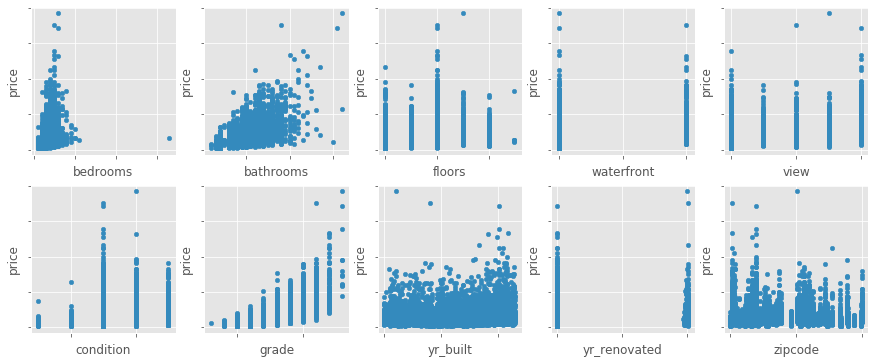

In [5]:
print_scatter(raw_df,categorical,outcome)

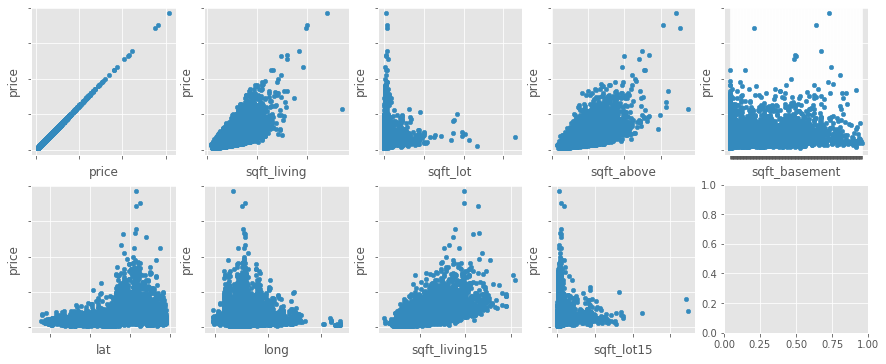

In [7]:
print_scatter(raw_df,continious,outcome)

### Data cleaning

#### Check for NaN

In [8]:
raw_df.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront        True
view              True
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated      True
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

#### Convert NaN to 0
`waterfront`, `view` and `yr_renovated` have NaN values.<br>
It's appropriate set them to 0<br>
Also cast them to int

In [3]:
raw_df = raw_df.fillna(0)
raw_df.waterfront = raw_df.waterfront.astype(np.int64)
raw_df.view = raw_df.view.astype(np.int64)
raw_df.yr_renovated = raw_df.yr_renovated.astype(np.int64)

#### Fix `sqft_basement` column

In [4]:
raw_df.sqft_basement = raw_df.sqft_basement.replace('?',0)
raw_df.sqft_basement = raw_df.sqft_basement.astype(np.float64)

#### trim data

In [5]:
raw_df = raw_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#### Remove outliers
(more than 3 std)

In [6]:
from scipy import stats
possible_outliers_cols = ['price','sqft_living','sqft_lot','sqft_above',
                          'sqft_basement','sqft_living15','sqft_lot15']
df = raw_df[(np.abs(stats.zscore(raw_df[possible_outliers_cols])) < 3).all(axis=1)]

# Remove 1 row with '33' value in bedrooms column as outlier
# print(df.bedrooms.max())
df = df[df.bedrooms != 33]

# Remove 1 row with '7.5' value in bathrooms column as outlier
# print(df.bathrooms.max())
df = df[df.bathrooms != 7.5]

print_reduce_perc(raw_df,df)

'Dataframe length -  before: 21597, after: 20339. Size reduction: 5.82%'

### Clean data visualization

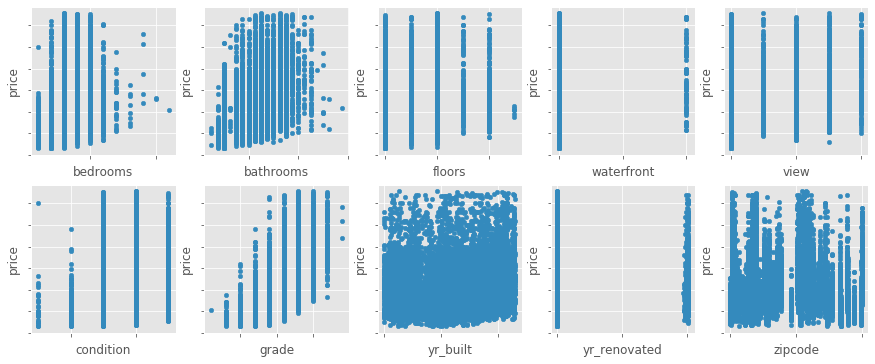

In [13]:
print_scatter(df,categorical,outcome)

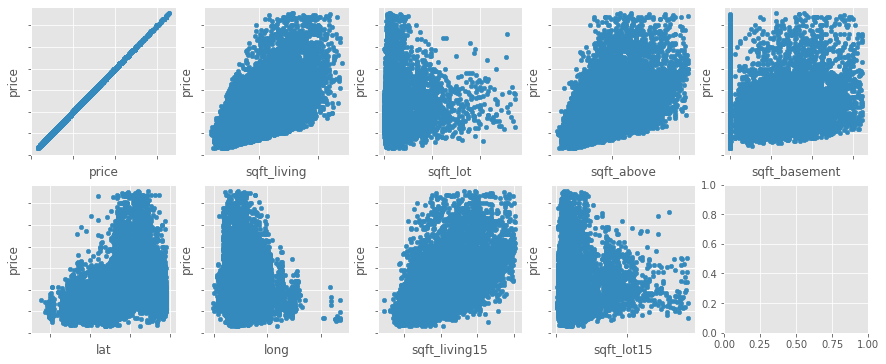

In [14]:
print_scatter(df,continious,outcome)

### Normalize data

#### Check data distribution

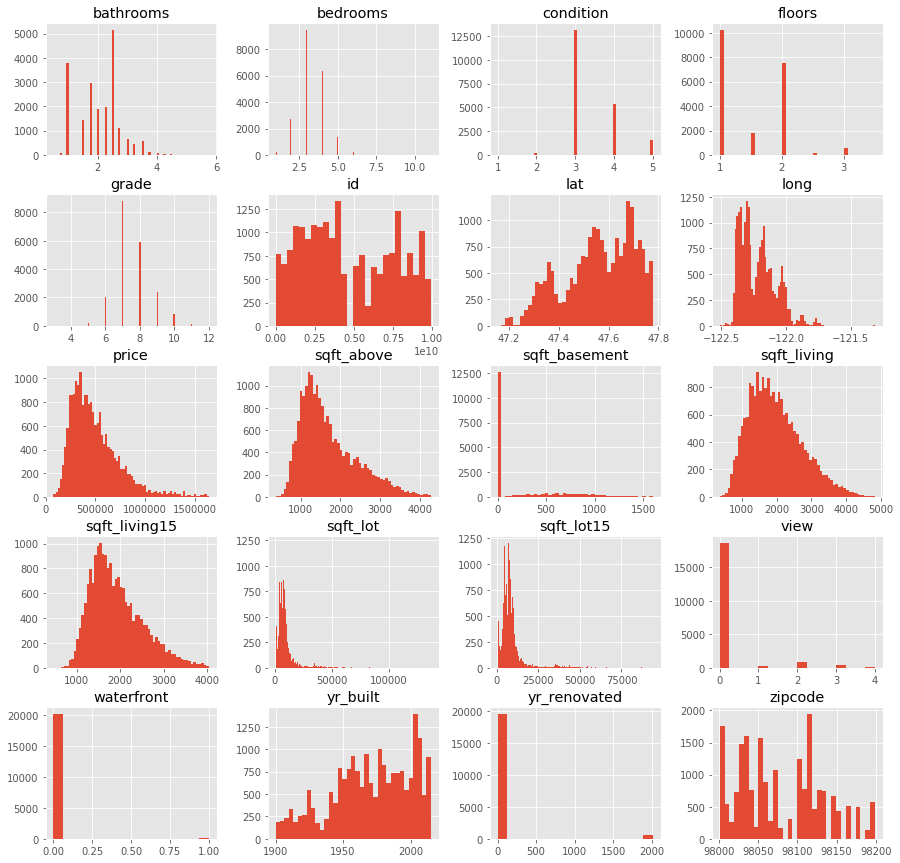

In [15]:
print_hist(df)

#### Cut df ot make data more normal
The `price`,`sqft_living`,`sqft_lot` are skewed, so we'll try to make them more normal

In [7]:
cropped_df = df[df['price'] < 1000000]
cropped_df = cropped_df[cropped_df['sqft_lot'] < 20000]
cropped_df = cropped_df[cropped_df['bedrooms'] < 7.5]

print_reduce_perc(df,cropped_df)

'Dataframe length -  before: 20339, after: 17990. Size reduction: 11.55%'

#### Check cropped data distribution

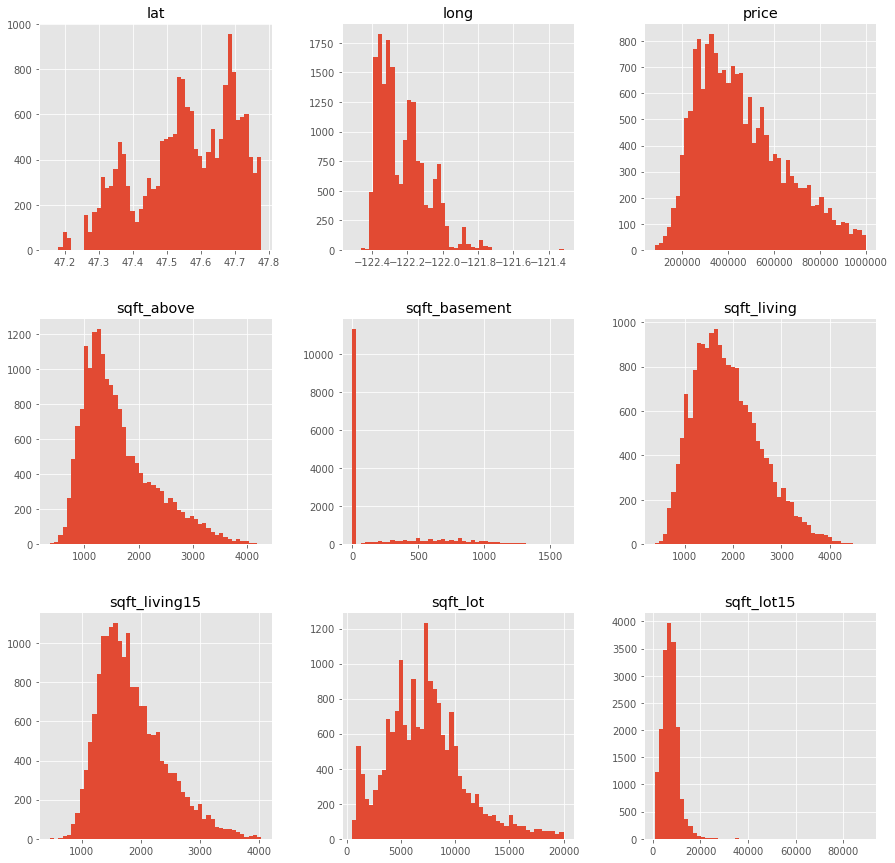

In [17]:
print_hist(cropped_df[continious], bins=50)

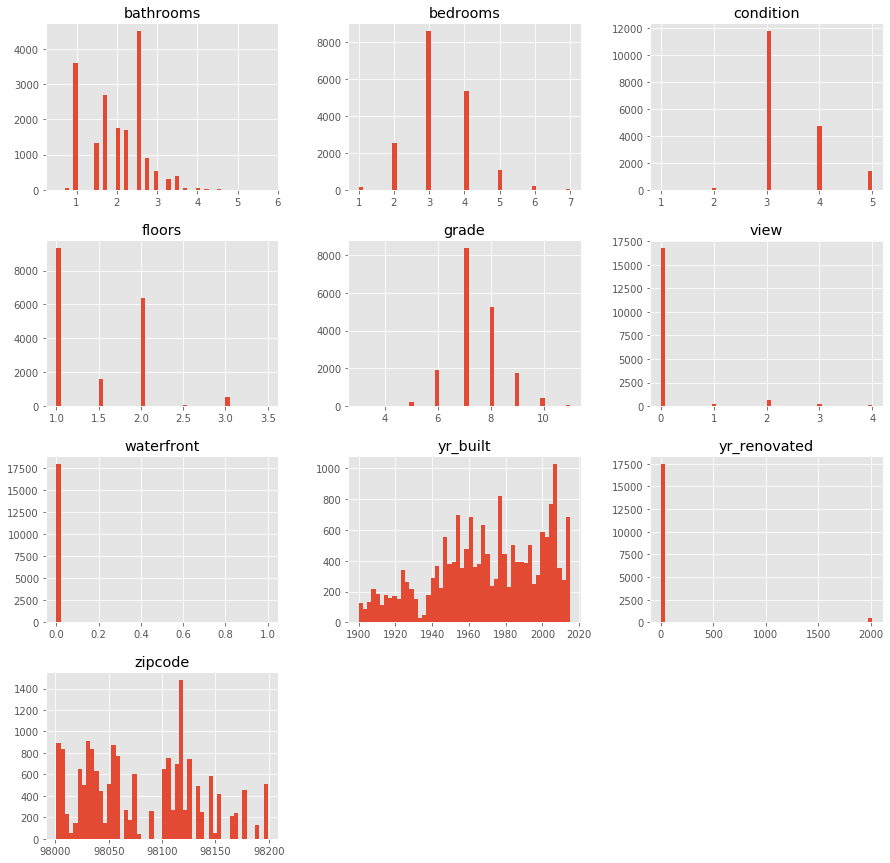

In [18]:
print_hist(cropped_df[categorical], bins=50)

### Plot data on map
print min and max values to export image from <a href="https://www.openstreetmap.org/">openstreetmap.org</a>

In [11]:
BBox = ((cropped_df.long.min(),   cropped_df.long.max(),      
         cropped_df.lat.min(), cropped_df.lat.max()))

BBox

(-122.512, -121.315, 47.1559, 47.7776)

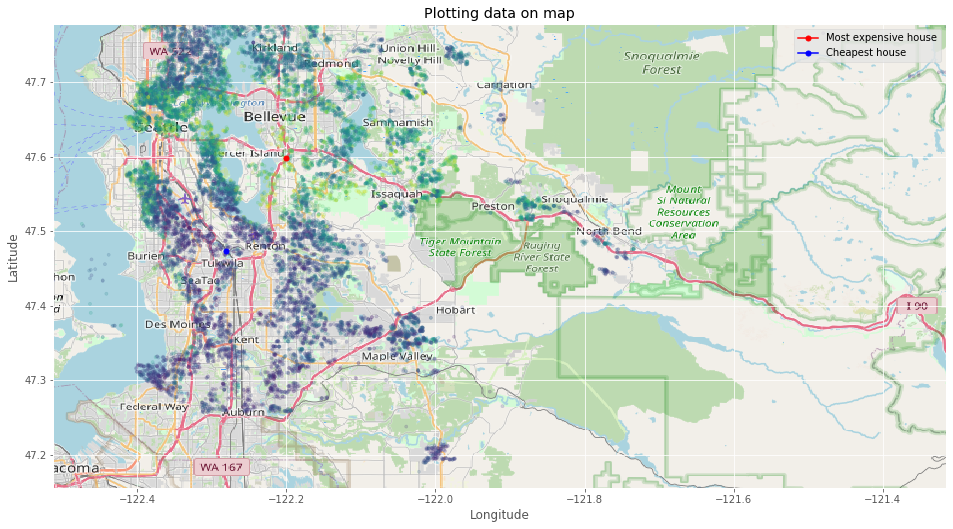

In [12]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(cropped_df.long, cropped_df.lat, zorder=1, alpha= 0.2, c=cropped_df.price, s=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title('Plotting data on map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

exp = cropped_df[cropped_df['price'] == cropped_df.price.max()][['long','lat']]
chp = cropped_df[cropped_df['price'] == cropped_df.price.min()][['long','lat']]

ax.plot(exp.long,exp.lat,c='r',markersize=5, marker='o', label="Most expensive house")
ax.plot(chp.long,chp.lat,c='b',markersize=5, marker='o', label="Cheapest house")
ax.legend(loc=1)

map_img = plt.imread('map.png')
ax.imshow(map_img, zorder=0, extent = BBox, aspect= 'equal');

# Questions

### What is dependence between `sqft_living` vs `price` and `sqft_lot` vs `price`?
From the visualization below we can see that square footage of living area impact price hardly with coefficient ~159.<br>
And square footage of lot has slight negative impact on price with coefficient -1.29.<br>
Sqft of living area impacts price about 100 times more than sqft of lot area.

sqft_living coefficient: 158.76592019128037
sqft_lot coefficient: -1.2912347265002777


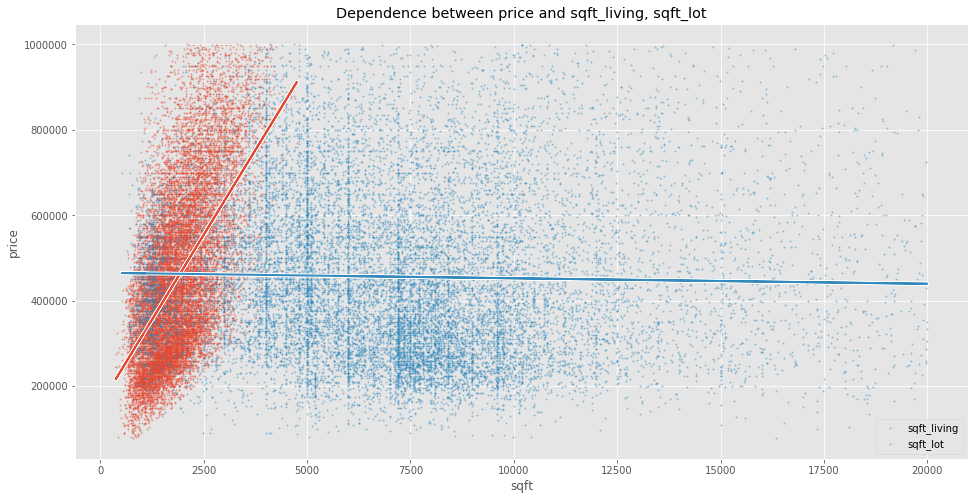

In [22]:
print_comparison(cropped_df[['sqft_living','price']],cropped_df[['sqft_lot','price']], x_label="sqft")

### Is there a difference in price based on the renovation status within the last 10 years or 10+ years with respect to square footage of living area?
From the visualization below we can see that year of renovation does not have an impact on house price.

sqft_living coefficient: 178.18482410890576
sqft_living coefficient: 178.85264575406347


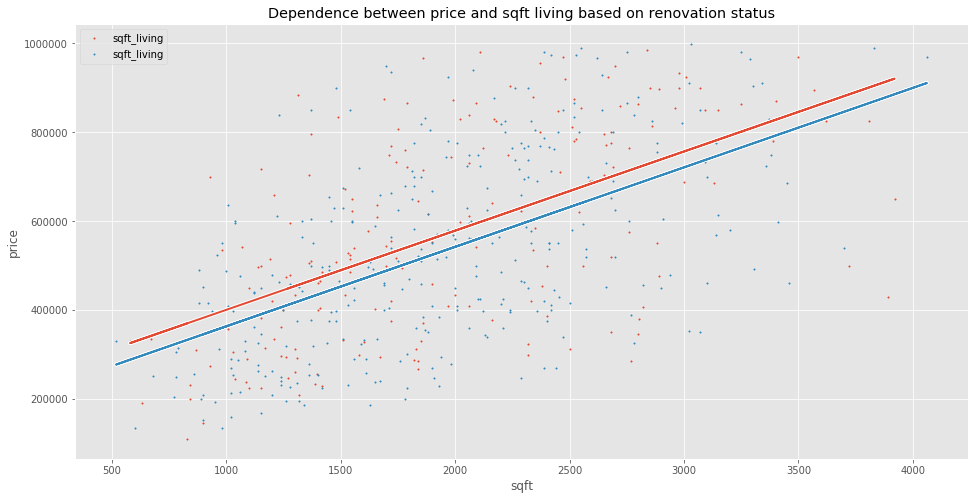

In [23]:
renovated_df = cropped_df[cropped_df.yr_renovated > 0]
renovated_df_less_10 = renovated_df[renovated_df.yr_renovated >= renovated_df.yr_renovated.max() - 10]
renovated_df_more_10 = renovated_df[renovated_df.yr_renovated < renovated_df.yr_renovated.max() - 10]
print_comparison(
    renovated_df_less_10[['sqft_living','price']],
    renovated_df_more_10[['sqft_living','price']], 
    title="Dependence between price and sqft living based on renovation status",
    x_label="sqft",
    alpha=1
)

### Does the price depend on the number of bedrooms? 
There is a notable difference in price between 1br and 2br apartments, as seen from the violin plot.<br>
The following increase in Br does not produce such a difference

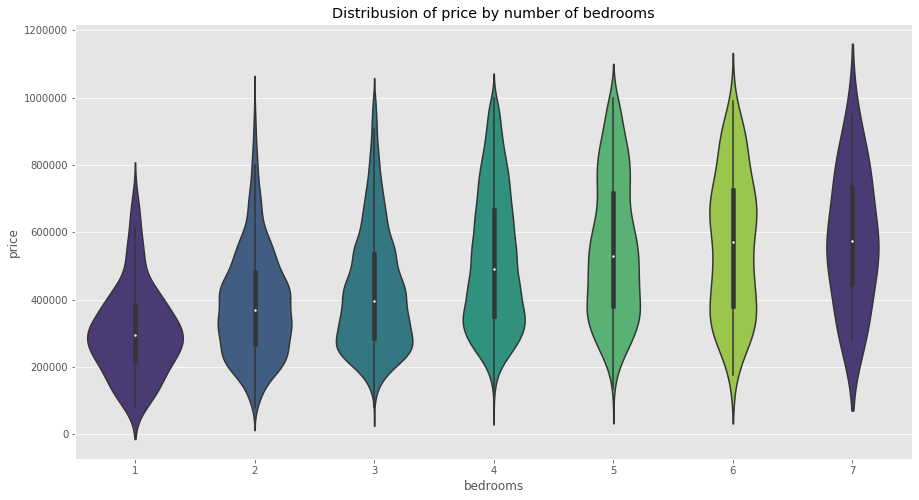

In [26]:
plt.figure(figsize=(15,8))
sns.violinplot(x="bedrooms", y="price", data=cropped_df,palette=sns.color_palette("viridis"))
plt.title('Distribusion of price by number of bedrooms');

Check significance with ANOVA

In [27]:
formula_b = 'price ~ sqft_living + C(zipcode) + C(grade) + C(bedrooms)'
lm = ols(formula_b, cropped_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq       df            F        PR(>F)
C(zipcode)   2.585771e+14     69.0   535.594470  0.000000e+00
C(grade)     1.399371e+13      8.0   249.998829  0.000000e+00
C(bedrooms)  5.728159e+11      6.0    13.644539  1.598807e-15
sqft_living  4.209516e+13      1.0  6016.269124  0.000000e+00
Residual     1.252793e+14  17905.0          NaN           NaN


### How did the price change over the time for the subset of data for which this data is available?
Select duplicated ids

In [28]:
duplicated_df = df[df.id.duplicated(keep=False)].sort_values('id')
duplicated_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2494,1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,0,0,...,7,2400,0.0,1991,0,98002,47.3262,-122.214,2060,7316
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,0,0,...,7,2400,0.0,1991,0,98002,47.3262,-122.214,2060,7316
16801,7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,0,0,...,6,840,0.0,1925,0,98055,47.4840,-122.211,1480,6969
16800,7200179,10/16/2014,150000.0,2,1.00,840,12750,1.0,0,0,...,6,840,0.0,1925,0,98055,47.4840,-122.211,1480,6969
11422,109200390,10/20/2014,250000.0,3,1.75,1480,3900,1.0,0,0,...,7,1480,0.0,1980,0,98023,47.2977,-122.367,1830,6956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6340,9828200460,1/6/2015,430000.0,2,1.00,700,4800,1.0,0,0,...,7,700,0.0,1922,0,98122,47.6147,-122.300,1440,4800
15185,9834200305,7/16/2014,350000.0,3,1.00,1790,3876,1.5,0,0,...,7,1090,0.0,1904,0,98144,47.5750,-122.288,1360,4080
15186,9834200305,2/10/2015,615000.0,3,1.00,1790,3876,1.5,0,0,...,7,1090,700.0,1904,0,98144,47.5750,-122.288,1360,4080
1084,9834200885,7/17/2014,360000.0,4,2.50,2080,4080,1.0,0,0,...,7,1040,1040.0,1962,0,98144,47.5720,-122.290,1340,4080


Convert data column (object) to date type and change format (without days).<br>
Sort values by date<br>
Group DF by date column

In [29]:
duplicated_df['date'] = pd.to_datetime(duplicated_df.date).dt.strftime('%Y-%m')
duplicated_df.sort_values('date', inplace=True)
duplicated_df_grouped = pd.DataFrame( duplicated_df.groupby('date')['price'].mean() ).reset_index()

Visualize data

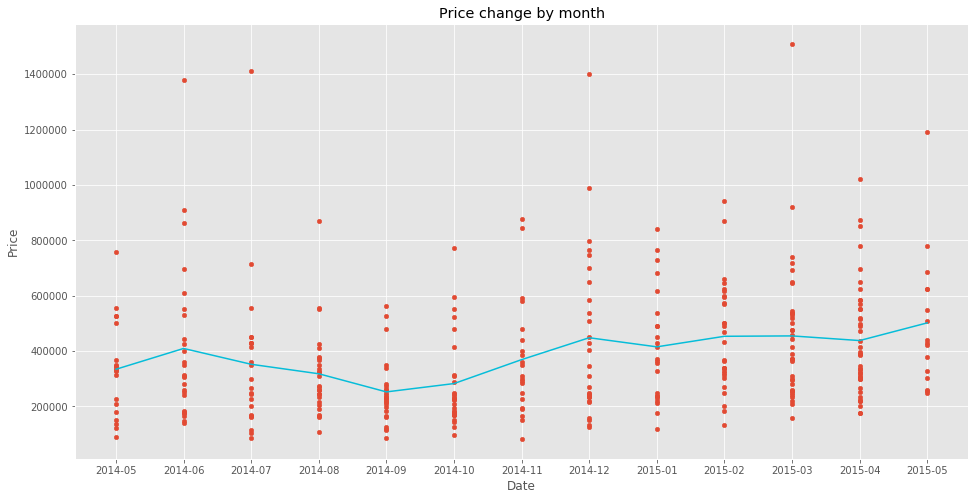

In [30]:
plt.figure(figsize=(16,8))
plt.scatter(duplicated_df.date, duplicated_df.price, s=20)
plt.plot(duplicated_df_grouped.date, duplicated_df_grouped.price, c="#06BDD9")
plt.title("Price change by month")
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

Conclusion:

In [31]:
d_df_start_price = round( duplicated_df_grouped[duplicated_df_grouped.date == '2014-05'].price[0],2 ) 
d_df_end_price = round( duplicated_df_grouped[duplicated_df_grouped.date == '2015-05'].price[12],2 ) 
print(f'The price increased from ${d_df_start_price} on 05/2014 to ${d_df_end_price} as of 05/2015')
print(f'The price increased by { round( (d_df_end_price*100) / d_df_start_price,0 ) }%')

The price increased from $334020.11 on 05/2014 to $501558.75 as of 05/2015
The price increased by 150.0%


# Build Model

I have tried to stepwise selection and recursive feature elimenation (RFE) but it didn't give meanful results.<br>
So I manually iterate over features and select minimum number of significant features.<br>
Next features do not change R squares significantly:
* bedrooms
* bathrooms
* view
* floors
* condition
* waterfront
* long
* sqft_lot
* sqft_lot15
* sqft_living15
* yr_renovated

Log transformation and normalization of  predictors did not increase R squared value significantly and complicated interpretation of the results.

In [10]:
cat_cols = ['zipcode']
cont_cols = ['sqft_living']

df_ohe = pd.get_dummies(cropped_df[cat_cols], columns=cat_cols, drop_first=True)
df_ohe.columns = df_ohe.columns.str.replace('.', '_')

# df_log_norm = log_norm(cropped_df,['price','sqft_living','sqft_lot'])
# X = pd.concat([df_log_norm[['sqft_living']], df_ohe], axis=1)
# y = df_log_norm[outcome]

X = pd.concat([cropped_df[cont_cols], df_ohe], axis=1)
y = cropped_df[outcome]

### Linear regression using Statsmodels

In [34]:
const_X = sm.add_constant(X)

model = sm.OLS(y, const_X)
linreg = model.fit()

linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     937.7
Date:                Wed, 07 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:10:43   Log-Likelihood:            -2.3045e+05
No. Observations:               17990   AIC:                         4.611e+05
Df Residuals:                   17919   BIC:                         4.616e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.768e+04   5404.084     -3.272      0.001   -2.83e+04   -7090.581
sqft_living     153.7797      1.046    146.985      0.000     151.729     155.830
zipcode_98002  1598.7197   8087.211      0.198      0.843   -1.43e+04    1.75e+04
zipcode_98003   1.57e+04   7429.704      2.113      0.035    1133.447    3.03e+04
zipcode_98004  5.263e+05   9426.588     55.829      0.000    5.08e+05    5.45e+05
zipcode_98005  3.662e+05   9789.111     37.406      0.000    3.47e+05    3.85e+05
zipcode_98006  3.166e+05   6990.966     45.291      0.000    3.03e+05     3.3e+05
zipcode_98007   2.79e+05   9272.519     30.092      0.000    2.61e+05    2.97e+05
zipcode_98008  2.656e+05   7508.918     35.374      0.000    2.51e+05     2.8e+05
zipcode_98010   9.16e+04   1.32e+04      6.945      0.000    6.58e+04    1.17e+05
zipcode_98011   1.61e+05   8291.553     19.414      0.000    1.45e+05    1.77e+05
zipcode_98014  1.024e+05   1.32e+04      7.765      0.000    7.66e+04    1.28e+05
zipcode_98019  9.614e+04   8952.213     10.740      0.000    7.86e+04    1.14e+05
zipcode_98022  2.298e+04   8846.476      2.597      0.009    5636.022    4.03e+04
zipcode_98023 -4671.8841   6488.738     -0.720      0.472   -1.74e+04    8046.667
zipcode_98024  1.318e+05   1.78e+04      7.404      0.000    9.69e+04    1.67e+05
zipcode_98027  2.498e+05   7564.111     33.025      0.000    2.35e+05    2.65e+05
zipcode_98028  1.475e+05   7519.436     19.614      0.000    1.33e+05    1.62e+05
zipcode_98029  2.619e+05   7228.350     36.226      0.000    2.48e+05    2.76e+05
zipcode_98030  9352.7594   7592.944      1.232      0.218   -5530.143    2.42e+04
zipcode_98031  1.885e+04   7508.316      2.510      0.012    4129.576    3.36e+04
zipcode_98032  2694.9473   9597.579      0.281      0.779   -1.61e+04    2.15e+04
zipcode_98033  3.328e+05   7023.486     47.388      0.000    3.19e+05    3.47e+05
zipcode_98034   1.93e+05   6401.040     30.145      0.000     1.8e+05    2.06e+05
zipcode_98038  3.792e+04   6423.688      5.904      0.000    2.53e+04    5.05e+04
zipcode_98039  6.874e+05      4e+04     17.186      0.000    6.09e+05    7.66e+05
zipcode_98040  4.718e+05   9230.386     51.115      0.000    4.54e+05     4.9e+05
zipcode_98042  1.692e+04   6551.136      2.582      0.010    4075.634    2.98e+04
zipcode_98045  1.097e+05   8968.451     12.232      0.000    9.21e+04    1.27e+05
zipcode_98052  2.802e+05   6400.989     43.782      0.000    2.68e+05    2.93e+05
zipcode_98053  2.642e+05   7688.937     34.355      0.000    2.49e+05    2.79e+05
zipcode_98055  4.511e+04   7484.722      6.027      0.000    3.04e+04    5.98e+04
zipcode_98056  1.127e+05   6778.608     16.622      0.000    9.94e+04    1.26e+05
zipcode_98058  4.709e+04   6747.671      6.978      0.000    3.39e+04    6.03e+04
zipcode_98059  1.106e+05   6789.225     16.284   

### Cross validation

In [12]:
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
regression = LinearRegression()
baseline = np.mean(cross_val_score(regression, X, y, cv=cross_validation, n_jobs=-1))
print(f'R squared mean: {baseline}')

R squared mean: 0.7834460884212766


### Linear regression using scikit-learn

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

yhat = lr.predict(X_test)

print(f'R-Squared : {lr.score(X_test, y_test)}')
print(f'Intercept: {lr.intercept_}')
print(f'sqft_living coefficient: {lr.coef_[0]}')

R-Squared : 0.7920266953770757
Intercept: -19963.70688185998
sqft_living coefficient: 155.73272857731214


### Check for multicollinearity
Print top 15 features with highest collinearity

In [104]:
print(X.corr().unstack().sort_values(ascending = False).drop_duplicates()[:15])

zipcode_98199  zipcode_98199    1.000000
zipcode_98075  sqft_living      0.173402
sqft_living    zipcode_98074    0.130860
               zipcode_98065    0.109423
zipcode_98052  sqft_living      0.097368
sqft_living    zipcode_98006    0.096410
               zipcode_98059    0.077432
               zipcode_98029    0.050988
               zipcode_98040    0.049677
               zipcode_98027    0.047126
               zipcode_98053    0.047120
zipcode_98011  sqft_living      0.045833
zipcode_98005  sqft_living      0.043074
zipcode_98038  sqft_living      0.042923
sqft_living    zipcode_98019    0.037078
dtype: float64


#### Print heatmap

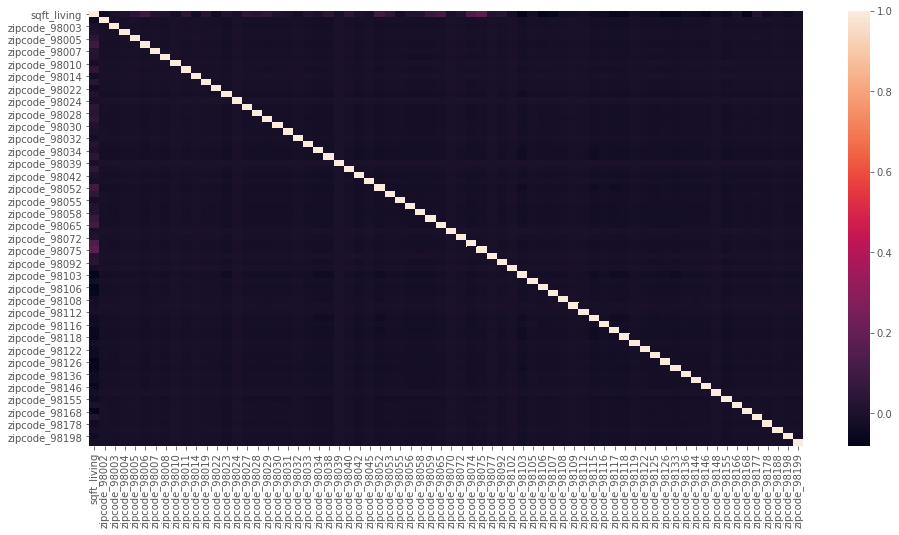

In [107]:
plt.figure(figsize=(16,8))
sns.heatmap(X.corr());

### Check for heteroscedascity

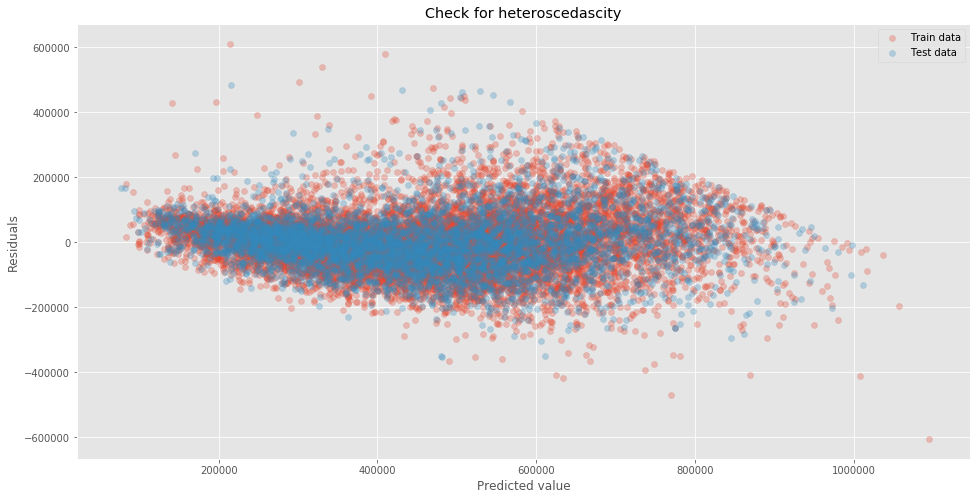

In [105]:
X_train_pred = lr.predict(X_train)
X_test_pred = lr.predict(X_test)
plt.figure(figsize=(16,8))
plt.scatter(X_train_pred, y_train - X_train_pred, label='Train data', alpha=.3)
plt.scatter(X_test_pred, y_test - X_test_pred, label='Test data', alpha=.3)
plt.title('Check for heteroscedascity')
plt.xlabel('Predicted value')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### Check for normality

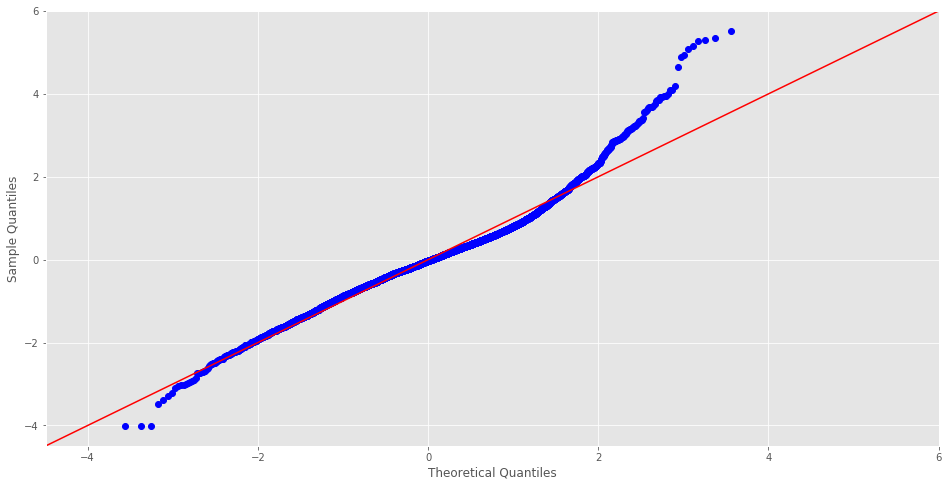

In [61]:
residuals = y_test - yhat
fig, ax = plt.subplots(figsize=(16,8))
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
plt.show()

#### Another residuals check option

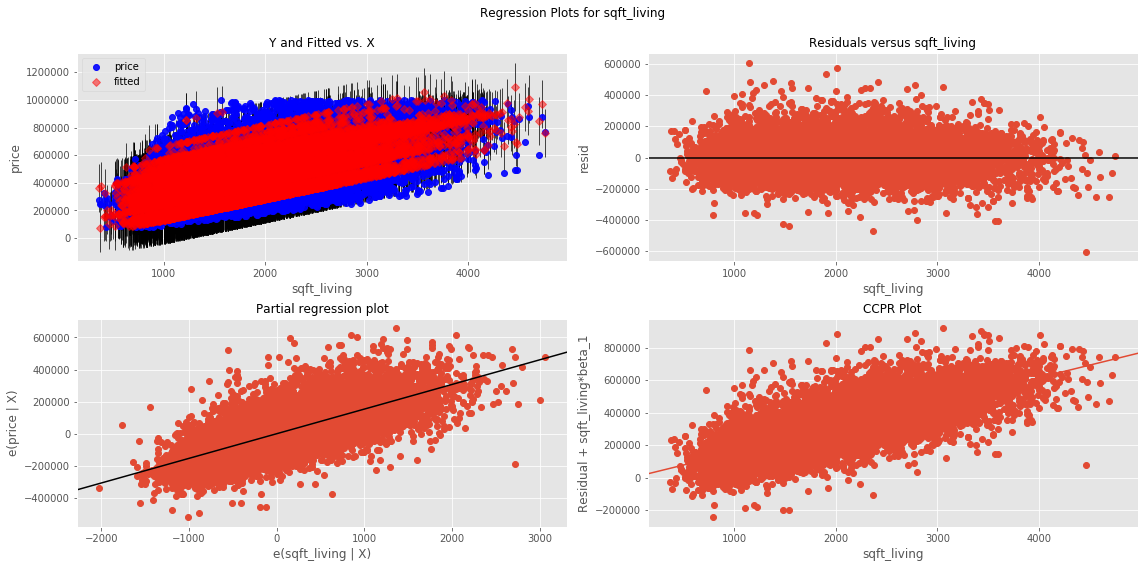

In [66]:
fig = plt.figure(figsize=(16,8))
fig = sm.graphics.plot_regress_exog(linreg, "sqft_living", fig=fig)
plt.show()

### Visualizing prediction accuracy

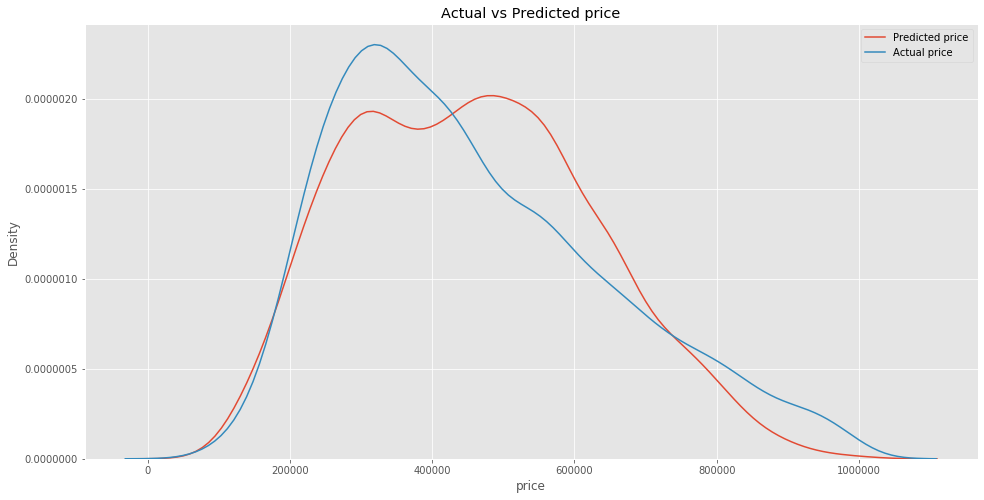

In [14]:
plt.figure(figsize=(16,8))
sns.distplot(yhat, hist = False, label = f'Predicted {outcome}')
sns.distplot(y_test, hist = False, label = f'Actual {outcome}')

plt.title(f'Actual vs Predicted {outcome}')
plt.xlabel(outcome)
plt.ylabel('Density')
plt.show()
#plt.savefig('model.png')

#### Save prepared data for further work

In [19]:
with open('processed_data.pickle', 'wb') as f:
    pickle.dump({'X': X,'y': y}, f, pickle.HIGHEST_PROTOCOL)

In [72]:
grouped_by_zipcode_df = pd.DataFrame( cropped_df.groupby('zipcode')['price'].mean() ).reset_index()
# grouped_by_zipcode_df.min() #zipcode 98001, price 233999.61
# grouped_by_zipcode_df.max() #zipcode 98199, price 881000.00

zipcode     98199.0
price      881000.0
dtype: float64

# Conclusions and recommendations

1. Zipcode is the most significant predictor of the price in this dataset. Zipcode is responsible for 52% of the R^2. As such, zipcode should be treated as the most essential piece of information about the property. 
2. Surprizingly, renovation status was not a significant predictor of the price, however, renovation status was available only for a small subset of data. It is reasonable to expect revonation status to be a significant and positive predictor of the property price.
3. Properties with large square footage did not fit well into the model. Thus, this model should only be used to predict price of medium size. (Limitation)
4. In addition, presence of "view" was not found to be significant. Interpretation for this variable was missing. Data for variable 'view' was available for only a small subset of data. 
